In [1]:
import json
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from datasets import load_dataset

from collections import Counter

In [2]:
sns.set(style="ticks", context="talk")
plt.style.use("dark_background")
plt.rcParams.update({"grid.linewidth":0.5, "grid.alpha":0.5})
sns.despine()

<Figure size 640x480 with 0 Axes>

In [3]:
mnli_dataset_classes = {
    -1: "unknown",
    0: "entailment",
    1: "neutral",
    2: "contradiction"
}

In [4]:
# Load the MNLI subset from GLUE
mnli_dataset = load_dataset('glue', 'mnli')

# Display the structure of the dataset
print("Data loaded!")
print(mnli_dataset)

Data loaded!
DatasetDict({
    train: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 392702
    })
    validation_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9815
    })
    validation_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9832
    })
    test_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9796
    })
    test_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9847
    })
})


# Access specific splits

The dataset is divided into several splits: 'train', 'validation_matched', 'validation_mismatched', 'test_matched', and 'test_mismatched'. You can access these splits like this:

In [5]:
# Access the training data
train_dataset = mnli_dataset['train']

# Access the validation matched data
validation_matched_dataset = mnli_dataset['validation_matched']

# Access the validation mismatched data
validation_mismatched_dataset = mnli_dataset['validation_mismatched']

# Access the test matched data
test_matched_dataset = mnli_dataset['test_matched']

# Access the test mismatched data
test_mismatched_dataset = mnli_dataset['test_mismatched']

# Print the first example in the training dataset
print(json.dumps(train_dataset[0], indent=4))

{
    "premise": "Conceptually cream skimming has two basic dimensions - product and geography.",
    "hypothesis": "Product and geography are what make cream skimming work. ",
    "label": 1,
    "idx": 0
}


# EDA: Exploratory Data Analysis

## Counting the number of tokens

In [6]:
# Load a model tokenizer as reference
from transformers import AutoTokenizer
model_name = "microsoft/phi-2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [7]:
stats = {
    "train": {
        "premise_counts": [],
        "hypothesis_counts": [],
    },
    "validation_matched": {
        "premise_counts": [],
        "hypothesis_counts": [],
    },
    "validation_mismatched": {
        "premise_counts": [],
        "hypothesis_counts": [],
    },
    "test_matched": {
        "premise_counts": [],
        "hypothesis_counts": [],
    },
    "test_mismatched": {
        "premise_counts": [],
        "hypothesis_counts": [],
    },
}

In [8]:
for partition_name in tqdm(stats.keys()):
    partition = mnli_dataset[partition_name]
    for example in tqdm(partition, leave=False):
        premise_tokens = tokenizer(example['premise']).input_ids
        hypothesis_tokens = tokenizer(example['hypothesis']).input_ids
        stats[partition_name]['premise_counts'].append(len(premise_tokens))
        stats[partition_name]['hypothesis_counts'].append(len(hypothesis_tokens))

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/392702 [00:00<?, ?it/s]

  0%|          | 0/9815 [00:00<?, ?it/s]

  0%|          | 0/9832 [00:00<?, ?it/s]

  0%|          | 0/9796 [00:00<?, ?it/s]

  0%|          | 0/9847 [00:00<?, ?it/s]

### Plot token statistics

<Figure size 640x480 with 0 Axes>

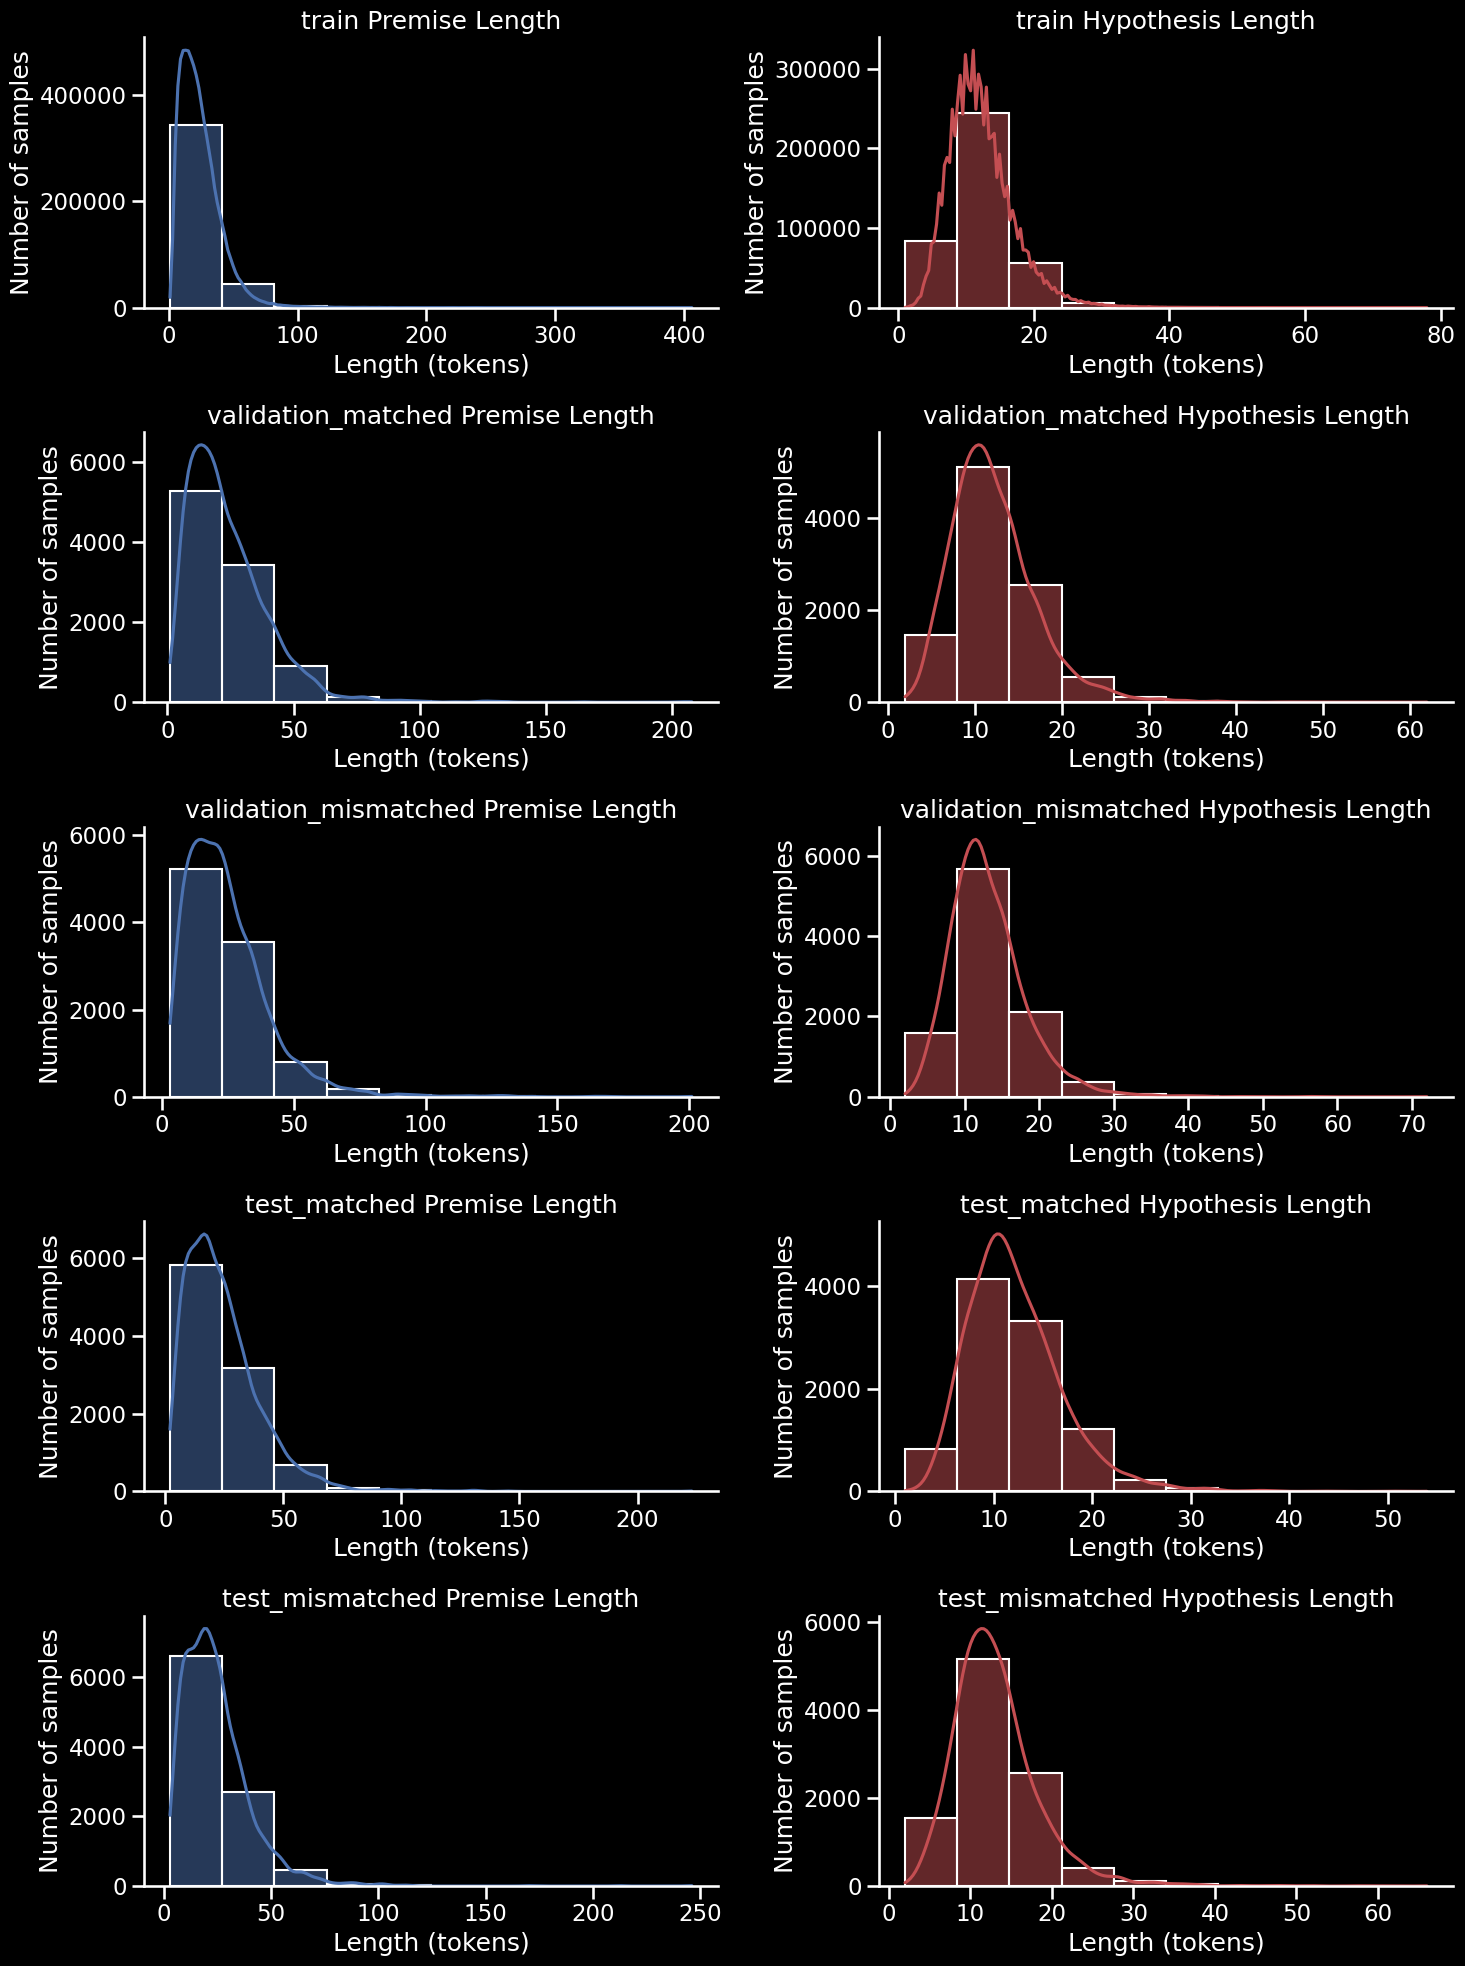

In [9]:
# Extract data
plt.tight_layout()
plt.show()

# Create histograms
fig, axes = plt.subplots(5, 2, figsize=(15, 20))

for i, partition_name in enumerate(stats.keys()):
    premise_counts = stats[partition_name]['premise_counts']
    hypothesis_counts = stats[partition_name]['hypothesis_counts']

    sns.histplot(premise_counts, bins=10, kde=True, ax=axes[i, 0], color='b')
    axes[i, 0].set_title(f'{partition_name} Premise Length')
    axes[i, 0].set_xlabel('Length (tokens)')  # Set x-axis label
    axes[i, 0].set_ylabel('Number of samples')        # Set y-axis label

    sns.histplot(hypothesis_counts, bins=10, kde=True, ax=axes[i, 1], color='r')
    axes[i, 1].set_title(f'{partition_name} Hypothesis Length')
    axes[i, 1].set_xlabel('Length (tokens)')  # Set x-axis label
    axes[i, 1].set_ylabel('Number of samples')        # Set y-axis label

sns.despine()

plt.tight_layout()
fig.savefig('assets/token_distribution.jpg', dpi=250, transparent=False)

plt.show()

## Count labels

In [10]:
# Count the number of unique labels in each partition
labels_instances = {
    "train": [],
    "validation_matched": [],
    "validation_mismatched": [],
    "test_matched": [],
    "test_mismatched": [],
}

for partition_name in tqdm(labels_instances.keys()):
    partition = mnli_dataset[partition_name]
    for example in tqdm(partition, leave=False):
        labels_instances[partition_name].append(
            mnli_dataset_classes[example['label']]
        )

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/392702 [00:00<?, ?it/s]

  0%|          | 0/9815 [00:00<?, ?it/s]

  0%|          | 0/9832 [00:00<?, ?it/s]

  0%|          | 0/9796 [00:00<?, ?it/s]

  0%|          | 0/9847 [00:00<?, ?it/s]

In [11]:
# Count the number of each label
label_counts = {
    partition_name: Counter(instances)
    for partition_name, instances in labels_instances.items()
}

label_counts

{'train': Counter({'contradiction': 130903,
          'neutral': 130900,
          'entailment': 130899}),
 'validation_matched': Counter({'entailment': 3479,
          'contradiction': 3213,
          'neutral': 3123}),
 'validation_mismatched': Counter({'entailment': 3463,
          'contradiction': 3240,
          'neutral': 3129}),
 'test_matched': Counter({'unknown': 9796}),
 'test_mismatched': Counter({'unknown': 9847})}

### Plot the label distribution

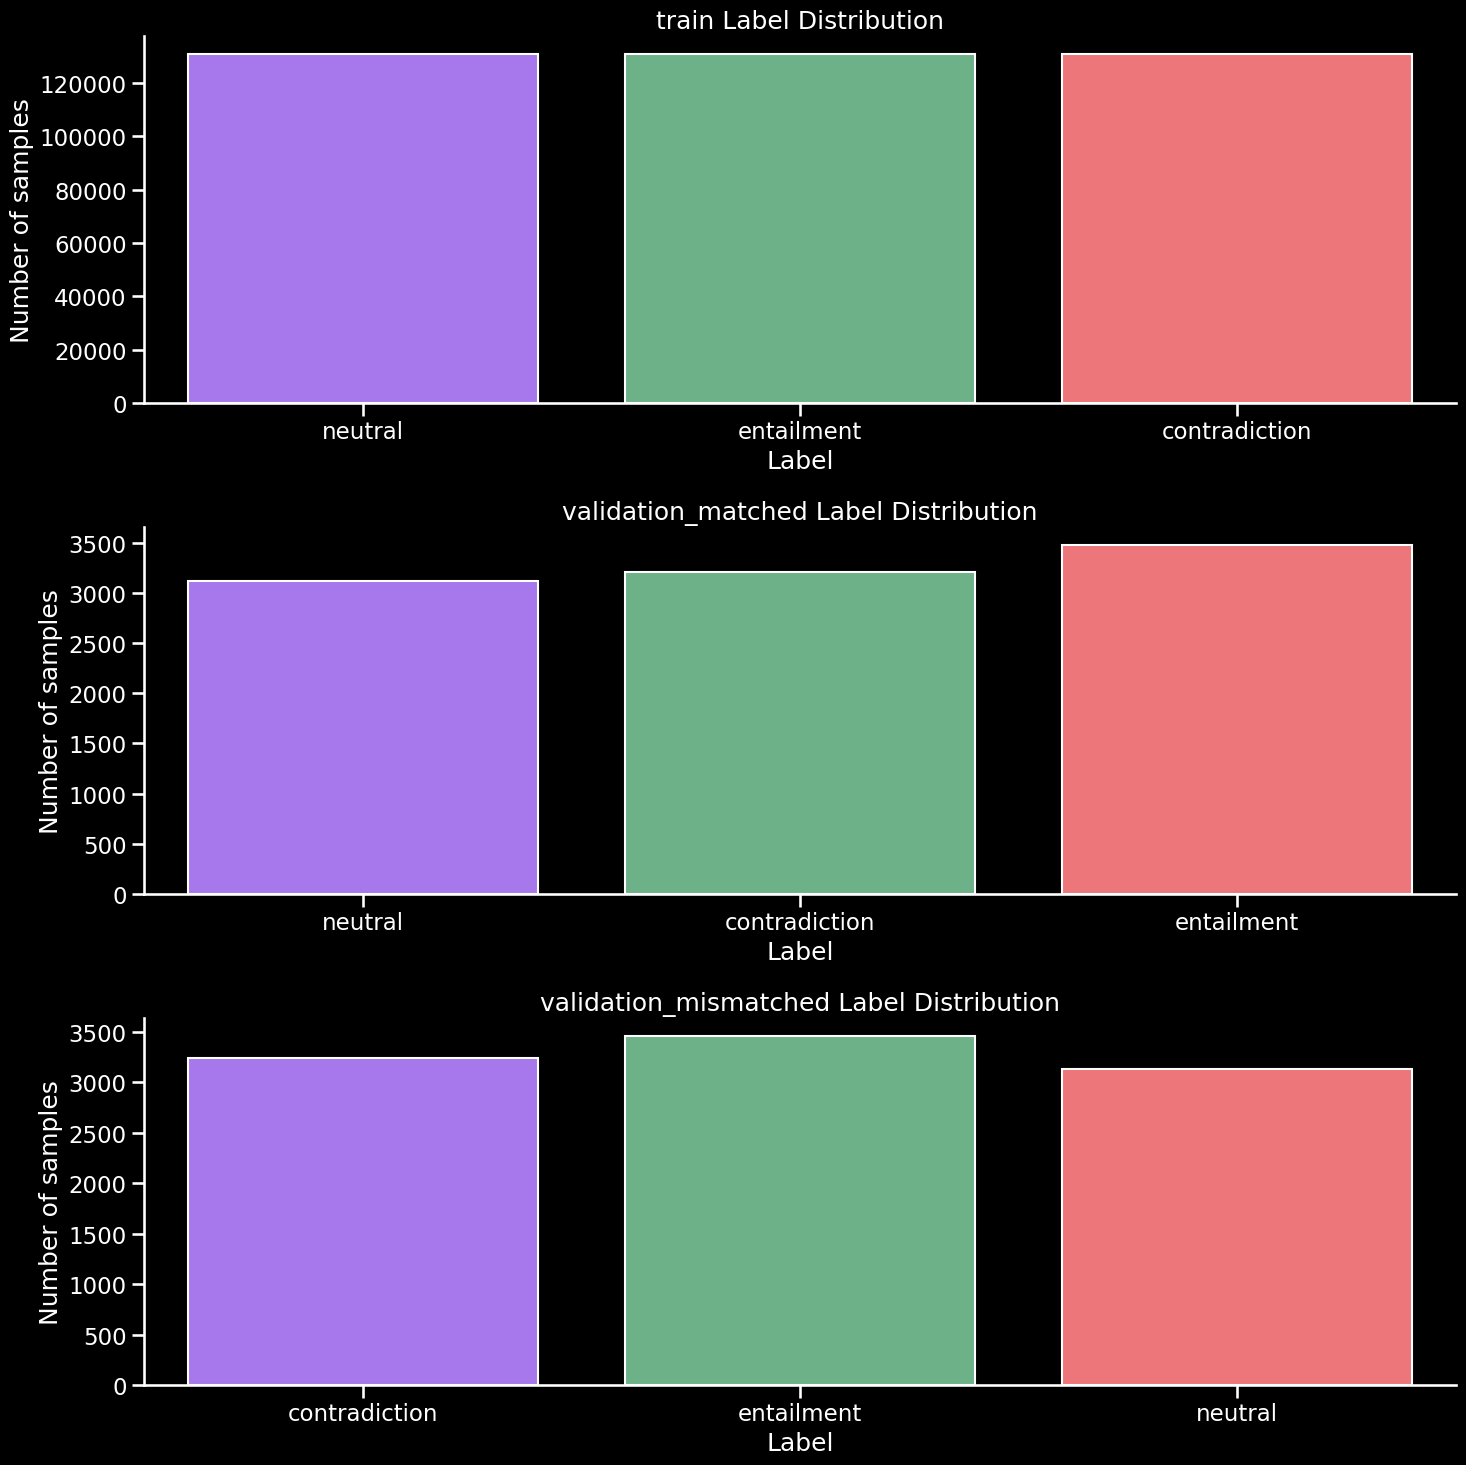

In [12]:
# Plot the label distribution for each partition
fig, axes = plt.subplots(3, 1, figsize=(15, 15))
color_list = ["#a364ff", "#61bc84", "#ff6366"]

for i, partition_name in enumerate(["train", "validation_matched", "validation_mismatched"]):
    labels = label_counts[partition_name]
    # Convert labels to a DataFrame for easier plotting with hue
    data = {'Label': list(labels.keys()), 'Count': list(labels.values())}
    df = pd.DataFrame(data)
    sns.barplot(x='Label', y='Count', hue='Label', data=df, ax=axes[i], palette=color_list, dodge=False)
    axes[i].set_title(f'{partition_name} Label Distribution')
    axes[i].set_xlabel('Label')  # Set x-axis label
    axes[i].set_ylabel('Number of samples')  # Set y-axis label
    
sns.despine()

plt.tight_layout()
fig.savefig('assets/label_distribution.jpg', dpi=250, transparent=False)

plt.show()